In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

Using TensorFlow backend.


In [2]:
data_dir = os.path.expanduser("./data/cora")

In [3]:
edgelist = pd.read_table(os.path.join(data_dir, "cora.cites"), header=None, names=["source", "target"])
edgelist["label"] = "cites"

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)

In [7]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In [8]:
train_data, test_data = model_selection.train_test_split(node_data, train_size=0.1, test_size=None, stratify=node_data['subject'])

In [9]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

In [10]:
node_features = node_data[feature_names]

In [11]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [12]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



In [13]:
batch_size = 50; num_samples = [10, 5]

In [14]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

In [15]:
train_gen = generator.flow(train_data.index, train_targets)

In [16]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32],
    generator=train_gen,
    bias=True,
    dropout=0.5,
)

In [17]:
x_inp, x_out = graphsage_model.default_model(flatten_output=True)
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [18]:
from keras.callbacks import ModelCheckpoint

model = Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy],
)

filepath="weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True, save_weights_only=False, period=1)
callbacks_list = [checkpoint]

In [19]:
test_gen = generator.flow(test_data.index, test_targets)

In [20]:
history = model.fit_generator(
    train_gen,
    epochs=25,
    validation_data=test_gen,
    verbose=1,
    shuffle=True,
    callbacks=callbacks_list,
)

Epoch 1/25
6/6 [==============================] - 4s 584ms/step - loss: 1.9049 - categorical_accuracy: 0.2196 - val_loss: 1.7535 - val_categorical_accuracy: 0.3372

Epoch 00001: val_loss improved from inf to 1.75346, saving model to weights-01.hdf5
Epoch 2/25
6/6 [==============================] - 3s 471ms/step - loss: 1.6691 - categorical_accuracy: 0.4052 - val_loss: 1.6149 - val_categorical_accuracy: 0.4094

Epoch 00002: val_loss improved from 1.75346 to 1.61491, saving model to weights-02.hdf5
Epoch 3/25
6/6 [==============================] - 3s 474ms/step - loss: 1.5412 - categorical_accuracy: 0.5458 - val_loss: 1.4628 - val_categorical_accuracy: 0.5308

Epoch 00003: val_loss improved from 1.61491 to 1.46275, saving model to weights-03.hdf5
Epoch 4/25
6/6 [==============================] - 3s 511ms/step - loss: 1.3527 - categorical_accuracy: 0.7594 - val_loss: 1.3173 - val_categorical_accuracy: 0.7281

Epoch 00004: val_loss improved from 1.46275 to 1.31734, saving model to weights-

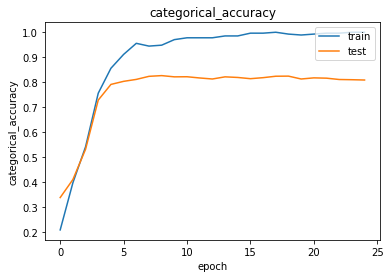

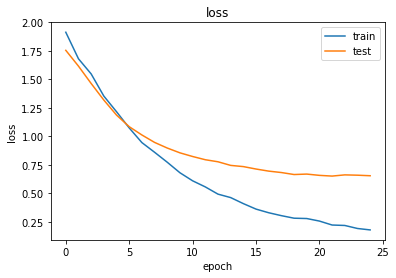

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
plot_history(history)

ITRERATION NO: 1
Loading weights...

Test Set Metrics:
	loss: 1.7524
	categorical_accuracy: 0.3388
Embedding data using tsne...
Plotting...


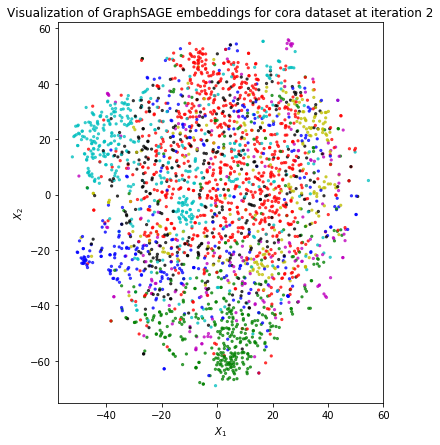

ITRERATION NO: 2
Loading weights...

Test Set Metrics:
	loss: 1.6131
	categorical_accuracy: 0.4114
Embedding data using tsne...
Plotting...


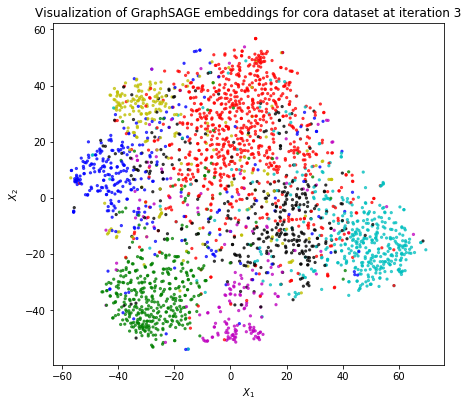

ITRERATION NO: 3
Loading weights...

Test Set Metrics:
	loss: 1.4619
	categorical_accuracy: 0.5369
Embedding data using tsne...
Plotting...


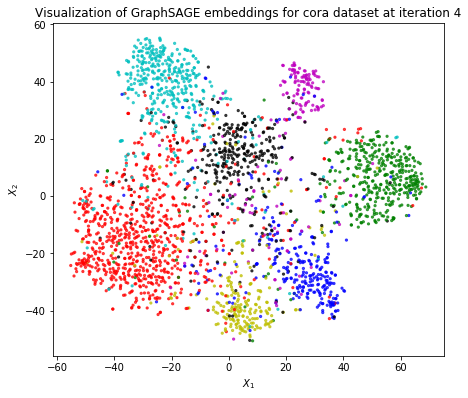

ITRERATION NO: 4
Loading weights...

Test Set Metrics:
	loss: 1.3182
	categorical_accuracy: 0.7285
Embedding data using tsne...
Plotting...


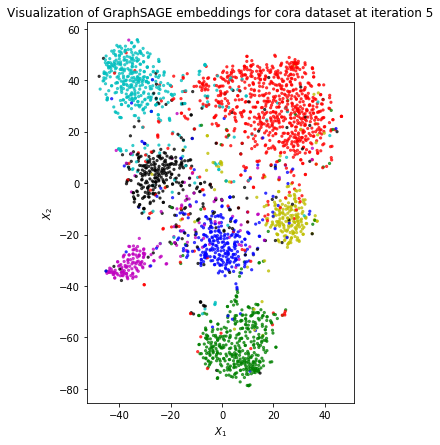

ITRERATION NO: 5
Loading weights...

Test Set Metrics:
	loss: 1.1821
	categorical_accuracy: 0.7990
Embedding data using tsne...
Plotting...


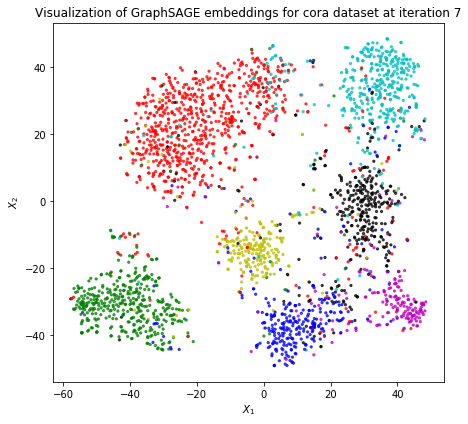

ITRERATION NO: 7
Loading weights...

Test Set Metrics:
	loss: 1.0103
	categorical_accuracy: 0.8130
Embedding data using tsne...
Plotting...


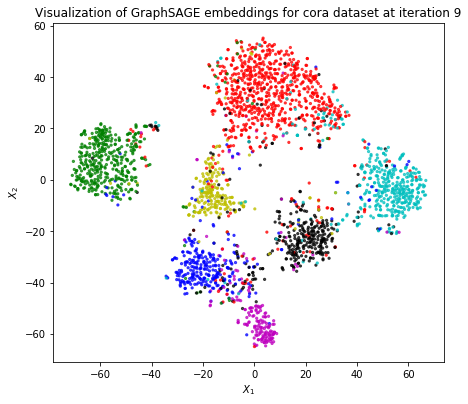

ITRERATION NO: 9
Loading weights...

Test Set Metrics:
	loss: 0.8942
	categorical_accuracy: 0.8265
Embedding data using tsne...
Plotting...


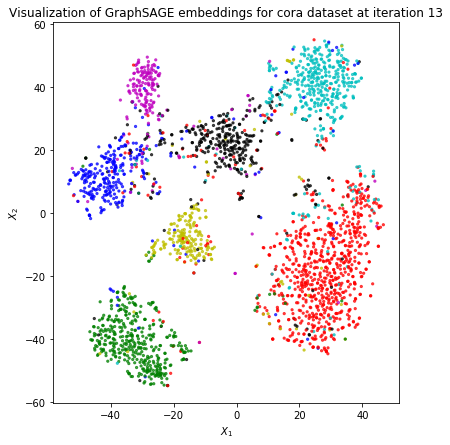

ITRERATION NO: 13
Loading weights...

Test Set Metrics:
	loss: 0.7702
	categorical_accuracy: 0.8126
Embedding data using tsne...
Plotting...


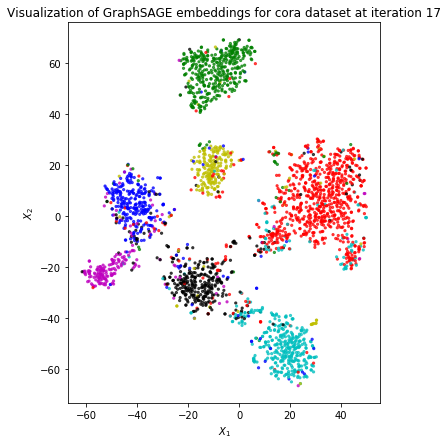

ITRERATION NO: 17
Loading weights...

Test Set Metrics:
	loss: 0.6900
	categorical_accuracy: 0.8216
Embedding data using tsne...
Plotting...


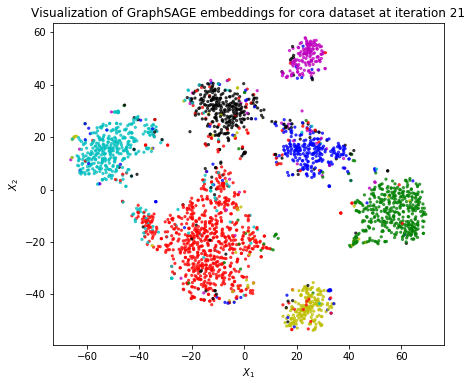

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from matplotlib.cm import rainbow

itno = 1

while itno < 20:
    print("ITRERATION NO: {}".format(itno))
    filename = "weights/weights-"
    if itno<10:
        filename = filename + str(0) + str(itno) + ".hdf5"
    else:
        filename = filename + str(1) + str(itno%10) + ".hdf5"
    
    # load weights
    print("Loading weights...")
    model.load_weights(filename)
    itno+=1
    if itno > 5:
        itno += 1
    if itno > 10:
        itno += 2
    
    # Print evaluation metric
    test_metrics = model.evaluate_generator(test_gen)
    print("\nTest Set Metrics:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))
        
    # load data
    all_nodes = node_data.index
    all_mapper = generator.flow(all_nodes)
    all_predictions = model.predict_generator(all_mapper)

    node_predictions = target_encoding.inverse_transform(all_predictions)

    results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
    df = pd.DataFrame({"Predicted": results, "True": node_data['subject']})
    # df.head(10)
    for nid, pred, true in zip(df.index, df["Predicted"], df["True"]):
        Gnx.node[nid]["subject"] = true
        Gnx.node[nid]["PREDICTED_subject"] = pred.split("=")[-1]

    for nid in train_data.index:
        Gnx.node[nid]["isTrain"] = True

    for nid in test_data.index:
        Gnx.node[nid]["isTrain"] = False

    for nid in Gnx.nodes():
        Gnx.node[nid]["isCorrect"] = Gnx.node[nid]["subject"] == Gnx.node[nid]["PREDICTED_subject"]
        
    # embedddings
    pred_fname = "pred_n={}.graphml".format(num_samples)
    nx.write_graphml(Gnx, os.path.join(data_dir,pred_fname))

    embedding_model = Model(inputs=x_inp, outputs=x_out)

    emb = embedding_model.predict_generator(all_mapper)
    emb.shape
    
    X = emb
    y = np.argmax(target_encoding.transform(node_data[["subject"]].to_dict('records')), axis=1)
    
    print("Embedding data using tsne...")
    if X.shape[1] > 2:
        transform = TSNE #PCA 

        trans = transform(n_components=2)
        emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_data.index)
        emb_transformed['label'] = y
    else:
        emb_transformed = pd.DataFrame(X, index=node_data.index)
        emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
        emb_transformed['label'] = y
    
    print("Plotting...")
    # plot data
    alpha = 0.7

    l=['b','g','r','c','y','m','k']
    colors = []
    for i in emb_transformed['label'].astype("category"):
        colors.append(l[int(i)])
        
    
    fig, ax = plt.subplots(figsize=(7,7))
    
    ax.scatter(emb_transformed[0], emb_transformed[1], c=colors
               , alpha=alpha,s=5)
    ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
    plt.title('Visualization of GraphSAGE embeddings for cora dataset at iteration {}'.format(itno))
    title = "Embeddings-at-iter-" + str(itno)
    plt.savefig(title)
    plt.show()

In [ ]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

In [ ]:
all_nodes = node_data.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_mapper)

node_predictions = target_encoding.inverse_transform(all_predictions)

results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data['subject']})
df.head(10)

In [ ]:
for nid, pred, true in zip(df.index, df["Predicted"], df["True"]):
    Gnx.node[nid]["subject"] = true
    Gnx.node[nid]["PREDICTED_subject"] = pred.split("=")[-1]

for nid in train_data.index:
    Gnx.node[nid]["isTrain"] = True
    
for nid in test_data.index:
    Gnx.node[nid]["isTrain"] = False

for nid in Gnx.nodes():
    Gnx.node[nid]["isCorrect"] = Gnx.node[nid]["subject"] == Gnx.node[nid]["PREDICTED_subject"]

In [ ]:
pred_fname = "pred_n={}.graphml".format(num_samples)
nx.write_graphml(Gnx, os.path.join(data_dir,pred_fname))

embedding_model = Model(inputs=x_inp, outputs=x_out)

emb = embedding_model.predict_generator(all_mapper)
emb.shape

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [ ]:
X = emb
y = np.argmax(target_encoding.transform(node_data[["subject"]].to_dict('records')), axis=1)

In [ ]:
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_data.index)
    emb_transformed['label'] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_data.index)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = y

In [ ]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha,s=5)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GraphSAGE embeddings for cora dataset'.format(transform.__name__))
plt.show()

In [ ]:
# node_data

In [ ]:
from collections import defaultdict
from itertools import count
from functools import partial

label_to_number = defaultdict(partial(next, count(1)))
my_dict = [label_to_number[label] for label in node_data['subject']]

# node_data[1434].astype("category")
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(emb_transformed[0], emb_transformed[1], c=[label_to_number[label] for label in node_data['subject']], 
            cmap="jet", alpha=alpha,s=5)

ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
# plt.legend()
plt.title('{} visualization of GraphSAGE embeddings for cora dataset'.format(transform.__name__))
plt.savefig(graphsage)
plt.show()

In [ ]:
ids=emb_transformed['label'].astype("category")
node_data = pd.read_table('./data/cora/cora.content', header=None)
label=node_data[1434]

In [ ]:
label2 = np.asarray(label)
ids2 = np.asarray(ids)
a1 = label2.reshape(2708,1) == label2.reshape(2708,)
a2 = ids2.reshape(2708,1) == ids2.reshape(2708,)

b1 = np.sum(a1==a2)
b2 = 2708*2708

print(a2)
print(ids2)
print(label2)

ans = 100*b1/b2
print(ans)

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score as ars
score = ars(label,ids)
print(score)

from sklearn.metrics.cluster import homogeneity_score as hs
score = hs(label,ids)
print(score)

from sklearn.metrics.cluster import completeness_score as cs
score = cs(label,ids)
print(score)

In [ ]:
a=0
b=0
for i in range(emb_transformed.shape[0]):
    for j in range(emb_transformed.shape[0]):
        if ids[i]==ids[j] and label[i]==label[j]:
            a=a+1
        elif ids[i]!=ids[j] and label[i]!=label[j]:
            a=a+1
        b=b+1
    print(i)

In [ ]:
print (100*a/b)